In [1]:
import findspark

In [2]:
findspark.init('/home/lakshmi/spark-2.4.5-bin-hadoop2.7')

In [3]:
from pyspark.sql import SparkSession

In [4]:
from pyspark.sql.functions import isnull, format_number

In [35]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [6]:
spark = SparkSession.builder.appName('customer_churn').getOrCreate()

Load the input data into a dataframe

In [7]:
df1= spark.read.csv(path='/media/sf_Ubuntu_Shared/customer_churn.csv', header=True, inferSchema=True)

In [8]:
df1.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Churn: integer (nullable = true)



Drop irrelevant columns

In [9]:
df1 = df1.drop('Names', 'Location', 'Onboard_date', 'Company')

In [10]:
df1.columns

['Age', 'Total_Purchase', 'Account_Manager', 'Years', 'Num_Sites', 'Churn']

In [11]:
df1.count()

900

Check for missing data

In [12]:
for col in df1.columns:
    df1.select(isnull(col).alias(col)).groupBy(col).count().show()

+-----+-----+
|  Age|count|
+-----+-----+
|false|  900|
+-----+-----+

+--------------+-----+
|Total_Purchase|count|
+--------------+-----+
|         false|  900|
+--------------+-----+

+---------------+-----+
|Account_Manager|count|
+---------------+-----+
|          false|  900|
+---------------+-----+

+-----+-----+
|Years|count|
+-----+-----+
|false|  900|
+-----+-----+

+---------+-----+
|Num_Sites|count|
+---------+-----+
|    false|  900|
+---------+-----+

+-----+-----+
|Churn|count|
+-----+-----+
|false|  900|
+-----+-----+



No missing data is observed in the input data provided

## Exploratory Data Analysis

Study the distribution of all the variables

In [13]:
sample = df1.sample(0.2, seed=2) # sample the dataset to draw histograms

In [14]:
row_list = sample.select('Age','Total_Purchase', 'Account_Manager', 'Years', 'Num_Sites', 'Churn').collect()

In [15]:
Age = [x[0] for x in row_list]
Tot_Purchase = [x[1] for x in row_list]
Acc_Mgr = [x[2] for x in row_list]
Years = [x[3] for x in row_list]
Num_Sites = [x[4] for x in row_list]
Churn = [x[5] for x in row_list]

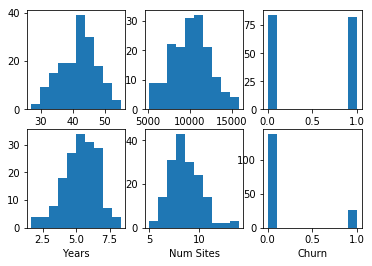

In [16]:
plt.subplot(231)
plt.hist(Age)
plt.xlabel('Age')
plt.subplot(232)
plt.hist(Tot_Purchase)
plt.xlabel('Total Purchase')
plt.subplot(233)
plt.hist(Acc_Mgr)
plt.xlabel('Account Manager')
plt.subplot(234)
plt.hist(Years)
plt.xlabel('Years')
plt.subplot(235)
plt.hist(Num_Sites)
plt.xlabel('Num Sites')
plt.subplot(236)
plt.hist(Churn)
plt.xlabel('Churn')
plt.show()

Distributions show moderate skewness which does not need any correction except for the target variable (Churn) which has imbalance.

In [17]:
df1.groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1|  150|
|    0|  750|
+-----+-----+



Owing to the imbalance in target data, we will need to evaluate the model predictions using Precision-Recall metrics.

In [18]:
numeric_df = df1.drop('Account_Manager','Churn')

In [19]:
numeric_df.columns

['Age', 'Total_Purchase', 'Years', 'Num_Sites']

In [20]:
limit = pd.DataFrame() #define a pandas df for storing lower & upper limits

In [21]:
k = 2 # constant for defining lower & upper limits

OUTLIER REMOVAL

In [22]:
for col in numeric_df.columns: #Calculate the lower and upper limits
    Q1, Q3 = numeric_df.select(col).approxQuantile(col, [0.25, 0.75], relativeError=0.01)
    IQR = Q3 - Q1
    limit.at['lower', col] = Q1 - k*IQR
    limit.at['upper', col] = Q3 + k*IQR

In [29]:
limit

,Age,Total_Purchase,Years,Num_Sites
lower,19.0,1919.54,1.19,1.0
upper,64.0,18188.49,9.29,16.0


In [30]:
for col in numeric_df.columns:
    df1 = df1.filter((df1[col] > limit.at['lower', col]) & 
                    (df1[col] < limit.at['upper', col]))

In [31]:
df1.count()

897

Study the correlation coefficient between input and target variables

In [32]:
features_df = sample.select('Age','Total_Purchase', 'Account_Manager', 'Years', 'Num_Sites', 'Churn').toPandas()

In [38]:
type(features_df)

pandas.core.frame.DataFrame

In [33]:
features_df.columns

Index(['Age', 'Total_Purchase', 'Account_Manager', 'Years', 'Num_Sites',
       'Churn'],
      dtype='object')

As the number of features is small, we are not filtering any features based on the correlation coefficient

PREPARE DATA FOR MODELLING

In [39]:
from pyspark.ml.feature import VectorAssembler

In [40]:
assembler = VectorAssembler(inputCols = ['Age', 'Total_Purchase', 'Account_Manager', 'Years', 'Num_Sites'],
                           outputCol = 'features')

In [41]:
full_data = assembler.transform(df1)

In [42]:
full_data.head(3)

[Row(Age=42.0, Total_Purchase=11066.8, Account_Manager=0, Years=7.22, Num_Sites=8.0, Churn=1, features=DenseVector([42.0, 11066.8, 0.0, 7.22, 8.0])),
 Row(Age=41.0, Total_Purchase=11916.22, Account_Manager=0, Years=6.5, Num_Sites=11.0, Churn=1, features=DenseVector([41.0, 11916.22, 0.0, 6.5, 11.0])),
 Row(Age=38.0, Total_Purchase=12884.75, Account_Manager=0, Years=6.67, Num_Sites=12.0, Churn=1, features=DenseVector([38.0, 12884.75, 0.0, 6.67, 12.0]))]

In [43]:
# Split data into train and test sets
train, test = full_data.randomSplit([0.7, 0.3], seed=2)

In [44]:
print('Training set count: ', train.count(), '\nTest set count: ', test.count())

Training set count:  618 
Test set count:  279


In [45]:
# Check if the label count in train and test datasets refelct the original dataset
train.groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1|  108|
|    0|  510|
+-----+-----+



In [46]:
# for test set
test.groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1|   42|
|    0|  237|
+-----+-----+



The label counts in train and test datasets approx. reflect the original dataset

## Model Fitting

In [48]:
from pyspark.ml.classification import LogisticRegression

In [104]:
logReg = LogisticRegression(labelCol='Churn', maxIter=1000, threshold=0.3)
# threshold is set to 0.3 to increase hit rate

In [105]:
logRegModel = logReg.fit(train) # fit the model

In [106]:
# print the model coefficients and intercept
logRegModel.coefficients

DenseVector([0.064, 0.0, 0.2578, 0.6693, 1.3265])

In [107]:
print('Model intercept: ', round(logRegModel.intercept, 4))

Model intercept:  -21.151


In [108]:
train.columns

['Age',
 'Total_Purchase',
 'Account_Manager',
 'Years',
 'Num_Sites',
 'Churn',
 'features']

## Model Evaluation

In [109]:
# Evaluate the model on test dataset
results = logRegModel.evaluate(test)

In [110]:
results.labels

[0.0, 1.0]

In [111]:
print('Accuracy: ', round(results.accuracy, 4))
print('False Positive Rate: ', results.falsePositiveRateByLabel)
print('Recall: ', results.recallByLabel)
print('Precision: ', results.precisionByLabel)
print('F1 Score: ', results.fMeasureByLabel())

Accuracy:  0.8889
False Positive Rate:  [0.30952380952380953, 0.0759493670886076]
Recall:  [0.9240506329113924, 0.6904761904761905]
Precision:  [0.9439655172413793, 0.6170212765957447]
F1 Score:  [0.9339019189765457, 0.651685393258427]


In [112]:
# calculate the metrics from scratch based on test dataset
rp = results.predictions
actual_positives = rp.filter(rp.Churn == 1).count()
actual_negatives = rp.filter(rp.Churn == 0).count()
true_positives = rp.filter((rp.Churn == 1) & (rp.prediction == 1.0)).count()
false_positives = rp.filter((rp.Churn == 0) & (rp.prediction == 1.0)).count()

In [113]:
Recall = true_positives / actual_positives
print('TPR or Recall: ', round(Recall, 4))

TPR or Recall:  0.6905


In [114]:
FPR = false_positives / actual_negatives
print('False Positive Rate : ', round(FPR, 4))

False Positive Rate :  0.0759


In [115]:
Precision = true_positives / (true_positives + false_positives)
print('Precision: ', round(Precision, 4))

Precision:  0.617


In [116]:
F1Score = 2 * Precision * Recall/(Precision + Recall)
print('F1Score: ', round(F1Score, 4))

F1Score:  0.6517


Metrics calculated by the LogisticRegressionSummary API match with the metrics calculated from scratch

In [160]:
prob = results.predictions.select('rawPrediction','probability','prediction','Churn')

In [161]:
prob.head(3)

[Row(rawPrediction=DenseVector([1.6649, -1.6649]), probability=DenseVector([0.8409, 0.1591]), prediction=0.0, Churn=0),
 Row(rawPrediction=DenseVector([3.8423, -3.8423]), probability=DenseVector([0.979, 0.021]), prediction=0.0, Churn=0),
 Row(rawPrediction=DenseVector([2.9687, -2.9687]), probability=DenseVector([0.9511, 0.0489]), prediction=0.0, Churn=1)]

CALCULATE "AREA UNDER ROC" and "AREA UNDER PR"

In [122]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [128]:
# Area Under ROC
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',
                        labelCol='Churn', metricName='areaUnderROC')

In [129]:
AUC_ROC = evaluator.evaluate(prob)

In [130]:
print("Area under ROC: ", round(AUC_ROC, 4))

Area under ROC:  0.8664


In [136]:
# Area under PR Curve
evaluator1 = BinaryClassificationEvaluator(rawPredictionCol='probability',
                        labelCol='Churn', metricName='areaUnderPR')

In [137]:
AUC_PR = evaluator1.evaluate(prob)

In [138]:
print("Area Under PR: ", round(AUC_PR, 4))

Area Under PR:  0.6862


## Predict customer churn on hold-out dataset

In [151]:
new_df = spark.read.csv(path="/media/sf_Ubuntu_Shared/new_customers.csv", 
              inferSchema=True, header=True)

In [152]:
new_df.count()

6

In [142]:
# Extract the numeric columns
new_df_numeric = new_df.select('Age', 'Total_Purchase', 'Account_Manager', 'Years', 'Num_Sites')

In [153]:
# Prepare the data
data = assembler.transform(new_df)

In [154]:
# Predict customer churn on the holdout data
output = logRegModel.transform(data)

In [157]:
# Print Churn prediction for each customer
output.select('Company','prediction').show()

+----------------+----------+
|         Company|prediction|
+----------------+----------+
|        King Ltd|       0.0|
|   Cannon-Benson|       1.0|
|Barron-Robertson|       1.0|
|   Sexton-Golden|       1.0|
|        Wood LLC|       0.0|
|   Parks-Robbins|       1.0|
+----------------+----------+

